In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import logit, glm

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')

/archive/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
quality = pd.read_csv('../data/quality.csv')
quality.head()

,MemberID,InpatientDays,ERVisits,OfficeVisits,Narcotics,DaysSinceLastERVisit,Pain,TotalVisits,ProviderCount,MedicalClaims,ClaimLines,StartedOnCombination,AcuteDrugGapSmall,PoorCare
0,1,0,0,18,1,731.0,10,18,21,93,222,False,0,0
1,2,1,1,6,1,411.0,0,8,27,19,115,False,1,0
2,3,0,0,5,3,731.0,10,5,16,27,148,False,5,0
3,4,0,1,19,0,158.0,34,20,14,59,242,False,0,0
4,5,8,2,19,3,449.0,10,29,24,51,204,False,0,0


In [3]:
# 0 for good care, 1 for poor care
quality.PoorCare.value_counts()

0    98
1    33
Name: PoorCare, dtype: int64

In [4]:
# baseline accuracy is in this case is num of good care / sample size.
# Our model should perform better than this.
98. / quality.shape[0]

0.7480916030534351

We need to randomly split our data into the test and train set. For now, I'll use python's random number generator. Ideally, we want the same rows as in R, but I'll only implement this when I know how to run R from Python.

In [6]:
'''
Split dataset into tran/ test sets , while maintaining the distribution found in the original TenYearCHD. 
from sklearn 0.18 & upwards, a lot of these modules have been moved to sklearn.model_selection 
'''
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)

for train_index, test_index in sss.split(quality, quality['PoorCare']):
    qualityTrain = quality.iloc[train_index,:]
    qualityTest = quality.iloc[test_index,:]


### Interpreting the Model

#### Multicollinearity could be a problem
- **Do the sign of the coefficients (+-) make sense?**
- **Check correlations between independent variables**, with Dataframe.corr()

In [8]:
# Logit regression using 
model = logit('PoorCare ~ OfficeVisits + Narcotics', qualityTrain).fit()
# same using GLM
# model = glm('PoorCare ~ OfficeVisits + Narcotics', qualityTrain, family=sm.families.Binomial()).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.438968
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               PoorCare   No. Observations:                   98
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            2
Date:                Thu, 18 Jan 2018   Pseudo R-squ.:                  0.2270
Time:                        19:18:17   Log-Likelihood:                -43.019
converged:                       True   LL-Null:                       -55.651
                                        LLR p-value:                 3.264e-06
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.2517      0.490     -4.594      0.000      -3.212      -1.291
OfficeVisits     0.0418

In [9]:
# AIC & BIC offer a measure to compare models ;  the smaller, the better.
model.aic, model.bic

(92.037796009694631, 99.79269844570635)

In [13]:
# use model to assess our predictions on the train set values
predict = model.predict(qualityTrain)
pd.Series(predict).describe()

count    98.000000
mean      0.255102
std       0.231474
min       0.095203
25%       0.132878
50%       0.159546
75%       0.243992
max       0.998449
dtype: float64

---

### Threshold Values, Confusion Matrix

In [14]:
# predicted values are probabilities , 
# using mask to turn them to True / False, and convert to int to get 0s/1s.
(predict >=0.5).astype(int) 

120    0
111    1
73     0
28     1
130    0
66     0
69     0
106    1
53     0
86     0
59     0
32     0
8      0
94     0
107    0
51     0
68     0
57     1
93     0
71     0
114    0
83     1
124    0
119    0
110    0
3      0
109    1
76     0
91     0
70     0
      ..
82     0
121    0
34     0
88     0
9      0
41     0
16     0
0      0
122    0
7      0
40     0
116    1
127    0
1      0
15     0
72     0
2      0
60     0
77     0
103    0
12     0
13     0
56     0
21     0
10     0
80     0
35     0
37     0
117    0
47     0
Length: 98, dtype: int32

In [11]:
'''
Function to create & display the confusion matrix for any threshold value, 
using ipywidgets to check how threshold values changes TPR, , TNR, ACC, ER
'''
def confusion_matrix(predict, actual, t=0.5):
    table = pd.DataFrame({'Model':(predict >= t).astype(int), 'Actual':actual})
    confusion_matrix = pd.crosstab(table.Model, table.Actual)
    total = confusion_matrix.values.sum()
    tpr = confusion_matrix.values[1,1] /(confusion_matrix.values[1,1] + confusion_matrix.values[0,1])
    fpr = confusion_matrix.values[1,0] /(confusion_matrix.values[1,1] + confusion_matrix.values[0,1])
    acc = (confusion_matrix.values[0,0] + confusion_matrix.values[1,1]) / total
    ter = (confusion_matrix.values[0,1] + confusion_matrix.values[1,0]) / total
    print('TPR : {:.2f} | FPR : {:.2f} | Accuracy : {:.2f} | Total Error : {:.2f}'.format(tpr, fpr, acc, ter))
    return confusion_matrix

In [15]:
from ipywidgets import interact, fixed

interact(confusion_matrix, predict=fixed(predict), actual=fixed(qualityTrain.PoorCare.values), 
         t=(0.0, 1.0, 0.05))

/archive/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


<function __main__.confusion_matrix>


### Threshold value (t) sets the rounding point for the projected probabilitites.

- `When t is small, True Negatives are more concrete, but False Positives are high. `

- `When t is large, True Positives are more concrete, but False Negatives are high.`

---

### Specificity and selectivity

Now that we built the model, we can check its specificity, sensitivity & accuracy. They are defined by:

- **Sensitivity** or **True Positive Rate** : the percentage of actual positives we classify correctly
- **Specificity** or **True Negative Rate** : the percentage of actual negatives we classify correctly
- **Accuracy**  : the percentage of correct classifications by our model


sensitivity | specificity | accuracy
----------- | ----------- | --------
$$\mathrm{\frac{TP}{TP+FN}}$$ | $$\mathrm{\frac{TN}{TN+FP}}$$ | $$\mathrm{\frac{TP+TN}{Sample Size}}$$ 

- A model with **high** threshold value , exhibits **low** sensitivity & **high** specificity.
- A model with **low** threshold value , exhibits **high** sensitivity & **low** specificity.


---

### Receiver Operator Characteristic  (ROC) Curve
- **How the True positive Rate** progresses in relation to the **False Positive Rate** (which basically is **(1-TrueNegativeRate)**), and the corresponding **threshold values** these trade-offs occur.

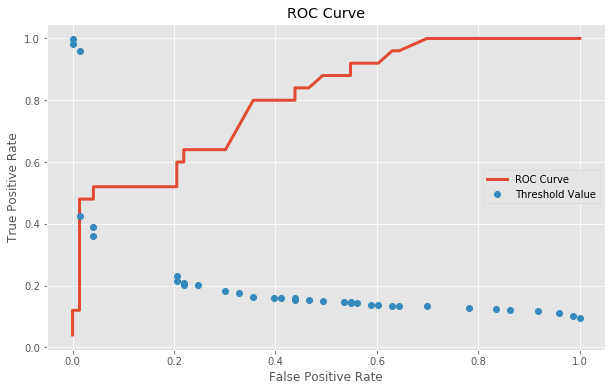

In [16]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(qualityTrain.PoorCare.values, predict)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve', linewidth=3)
plt.plot(fpr, thresholds, '.',markersize=12, label='Threshold Value')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=7)

### Accuracy
- ** Area under the ROC Curve (AUC)**
    - Signifies the probability of, given a random positive and negative, guessing which is which correctly.
    - Less affected by sample balance than accuracy.
- **What is a good AUC?**
    - Maximum of 1 (perfect prediction)
    - Minimum of 0.5 (just guessing)

In [40]:
# Area under the ROC Curve
from sklearn.metrics import roc_auc_score

roc_auc_score(qualityTrain.PoorCare.values, predict)

0.7745215311004785

### Need to differentiate between Accuracy & Area under the ROC Curve.

- Accuracy, TPP, TNR, etc. , evaluate the binary prediction strength (Yes/No, True/False).

- ROC & AUC evaluate the actual probabilities, i.e. the nodel's ability to distinguish between good & poor.  

---